# Session 5: Fitting Multiple Curves with One Model

### Goals:

1. Linear Data, Linear Model
2. Quad Data, Linear Model
3. Quad Data, Quad Model

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

import seaborn as sns
import torch
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)

In [3]:
def viz_1d(X, Y, title = None):
    
    if isinstance(Y, torch.Tensor):
        Y = Y.detach()
        
    plt.figure(figsize=(7, 4))
    if title:
        plt.title(title)
    plt.scatter(X, Y)
    plt.show()

def viz_pred(X, Y, Y_, title=None):
    
    if isinstance(Y_, torch.Tensor):
        Y_ = Y_.detach()
        
    plt.figure(figsize=(14, 10))
    if title:
        plt.title(title)
        
    plt.plot(X, Y, 'o')
    plt.plot(X, Y_, '+')
#     plt.scatter(X, Y, color='red')
    plt.show()
    
def viz_all(model, inputs=None, outputs= None, predictions= None, ax=None, grid=None):
    if grid:
        _X = torch.tensor(np.mgrid[grid[0]:grid[1]:grid[2]])
    elif inputs:
        inputs_scale = (inputs.max()-inputs.min())/10.0
        _X = torch.tensor(np.mgrid[inputs.min()-inputs_scale: inputs.max()+inputs_scale:0.1])
    else:
        grid = (-2, 2, 0.1) if grid is None else grid
        _X = torch.tensor(np.mgrid[grid[0]:grid[1]:grid[2]])
        
    with torch.no_grad():
        try:
            _Y = model(_X).detach()
        except RuntimeError:
            _Y = model(_X.unsqueeze(1).float()).detach()
        
    if ax is None: 
        fig = plt.figure(figsize=(14, 8), dpi=100)
        ax = fig.add_subplot(111)
        old_ax = False
    else:
        old_ax = True
    
    ax.plot(_X, _Y, label='model')
    
    if outputs is not None and inputs is not None:
        ax.scatter(inputs, outputs,  c='b', marker="s", label='Y Gold')
    
    if predictions is not None:
        ax.scatter(inputs, predictions, c='r', marker='+', label='Y Pred')
    

    if not old_ax:
        plt.legend(loc='upper left')
        plt.show()

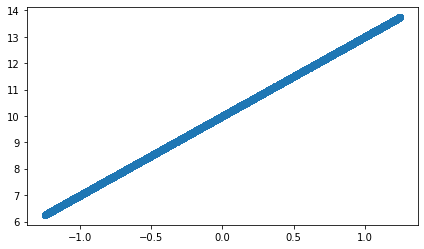

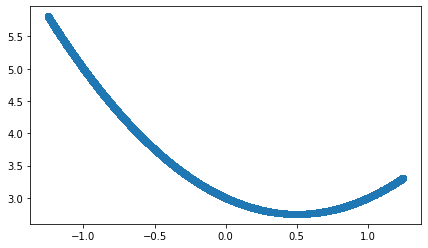

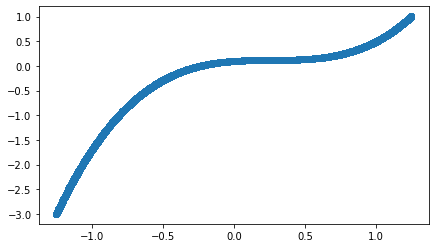

(None, None, None)

In [4]:

def true_fn_lin(x):
    return 3*x + 10

def true_fn_quad(x):
    return x**2 - (x) + 3

def true_fn_cubic(x):
    return 0.9*(x**3) - 0.7*(x**2) + 0.2*x + 0.1

n_samples = 10000
X = torch.randint(-500, 500, (n_samples,1)).float() / 400
# X = torch.randn(n_samples,1)
Y_lin = torch.tensor([true_fn_lin(x) for x in X])
Y_quad = torch.tensor([true_fn_quad(x) for x in X])
Y_cubic = torch.tensor([true_fn_cubic(x) for x in X])
fx = lambda x : (m*x) + c
viz_1d(X, Y_lin), viz_1d(X, Y_quad), viz_1d(X, Y_cubic)

# Model Description

In [88]:
class NonLin(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        self.t1 = torch.nn.Linear(1, 10) # 10 + 10
        self.t2 = torch.nn.Linear(10, 10) # 100 + 10
        self.t3 = torch.nn.Linear(10, 1) # 10 + 1
        
    def forward(self, x):
        x = F.sigmoid(self.t1(x))
        x = F.sigmoid(self.t2(x))
        x = self.t3(x)
        return x
    

/home/priyansh/Dev/perm/conda/envs/main/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


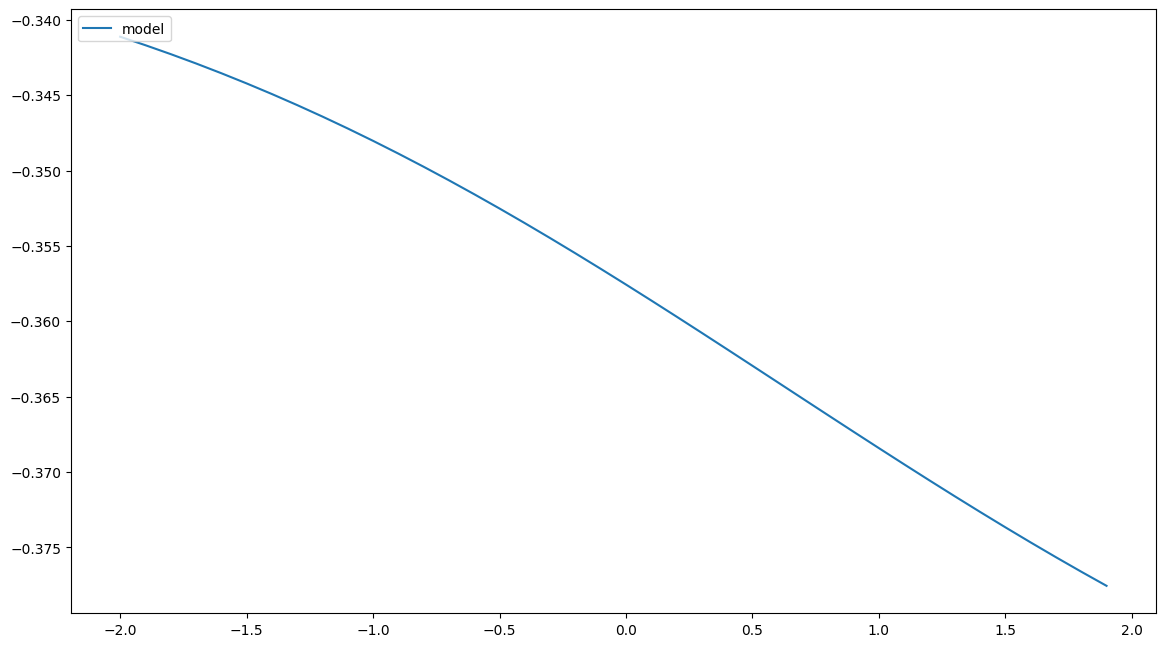

In [89]:
m = NonLin()
viz_all(m)

# Model, Hyperparams, Optimizer and Loss Function

In [90]:
torch.nn.MSELoss()

MSELoss()

In [100]:
# Hyperparams
epochs = 2000
lr = 0.1

# Model, Optimizer, and loss fn
m = NonLin()
opt = torch.optim.Adam(m.parameters(), lr=lr)
lfn = torch.nn.MSELoss(reduction='mean')

# Your Recepie goes here

In [101]:
X = X
Y = Y_cubic

# Training Loop

Model fully converged at 253. Stopping.


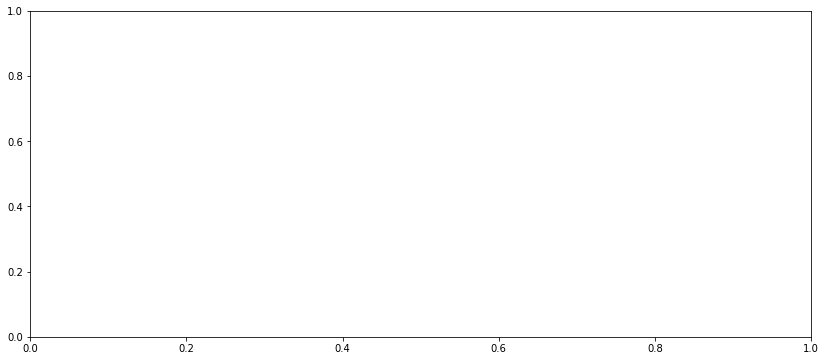

In [102]:

fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(111)
# xlim = (-1,2, 1.2)
# ylim = (-1, 14)
# ax1.set_xlim(-1.2, 1.2)
# ax1.set_ylim(-1, 14)
losses = []
continue_for = 0

# our dataset = X, Y

for e in range(epochs):

    opt.zero_grad() 
    
    # Lets sample a batch
    Xrange = torch.randint(0, n_samples, (200, ))
    _X = X[Xrange]
    _Y = Y[Xrange]
    
    # Make model predictions
    Y_pred = m(_X)
    
    # Calculate Loss
    loss = lfn(Y_pred, _Y.unsqueeze(1))
    
    loss.backward()    
    losses.append(loss.item())

    opt.step()
    
    with torch.no_grad():
        ...
        print(f"{e:5}: {loss.item():.5f}")
#         viz_all(model=m, inputs=X, outputs=Y, ax=ax1, grid=(-5, 5, 0.3))
        display.display(plt.gcf())

    
    if continue_for == 0:
        cmd = input('$: ')
        if cmd.lower().strip() in ['quit', 'q', 'exit', 'stop']:
                break
        else:
            try:
                continue_for = max(0, int(cmd.lower().strip()))
            except ValueError:
                ...
    else:
        continue_for -= 1
    
    display.clear_output(wait =True)
    plt.cla()

    
    if loss.item() < 0.001:
        print(f'Model fully converged at {e}. Stopping.')
        break

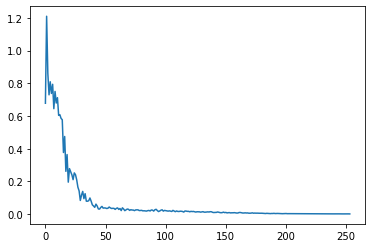

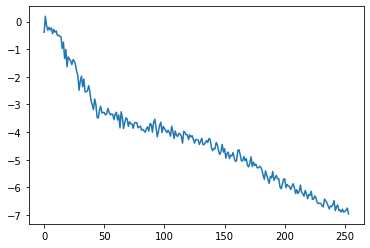

In [103]:


plt.plot(losses)
plt.show()
plt.plot(torch.log(torch.tensor(losses)))
plt.show()

/home/priyansh/Dev/perm/conda/envs/main/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


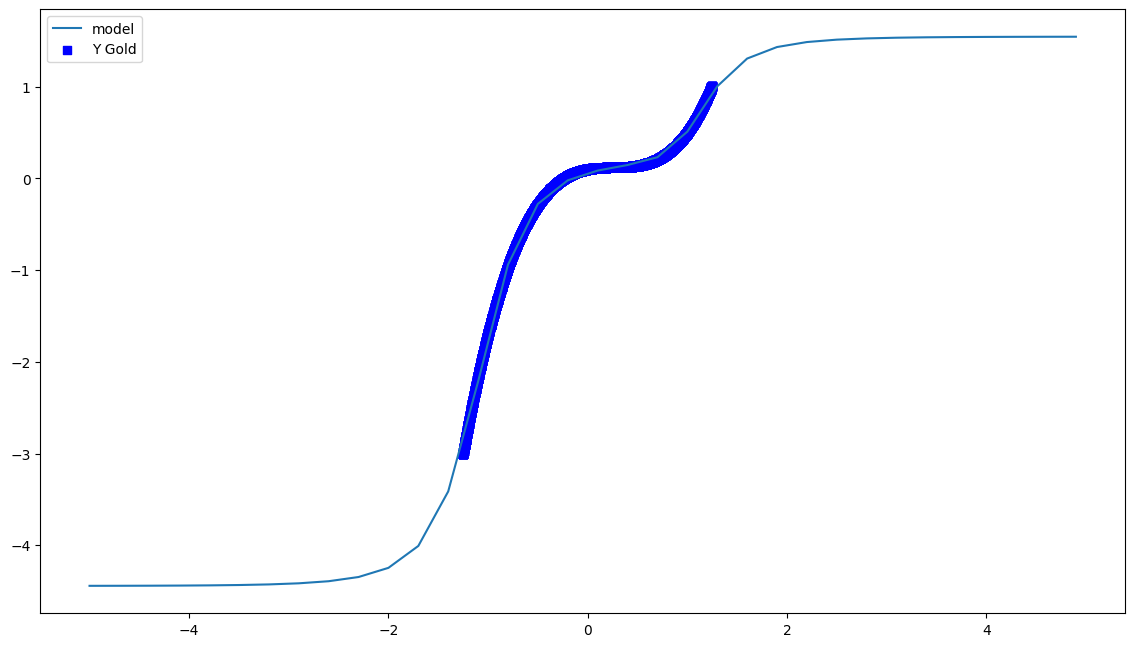

In [104]:
viz_all(model=m, inputs=X, outputs=Y, grid=(-5, 5, 0.3))